# Chi-square minimization for multiple observed spectra

Forward modeling of multiple spectra for the same object by minimizing the chi-square statistics between the data and atmospheric models.

In [1]:
import seda # import the seda package
import importlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, StrMethodFormatter, NullFormatter
from astropy.io import fits, ascii


    SEDA package imported


Read the observed spectra of interest.

As an example here, let's read the near-infrared IRTF/SpeX and the mid-infrared Spitzer/IRS spectra for the T8 (~750 K) brown dwarf 2MASS J04151954-0935066 in [Burgasser et al. (2004)](https://ui.adsabs.harvard.edu/abs/2004AJ....127.2856B/abstract) and [Suárez & Metchev (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.5701S/abstract), respectively.

Read SpeX spectrum:

In [2]:
# SpeX spectrum
SpeX_name = 'data/IRTF_SpeX_0415-0935.dat'
SpeX = ascii.read(SpeX_name)
wl_SpeX = SpeX['wl(um)'] # um 
flux_SpeX = SpeX['flux(erg/s/cm2/A)'] # erg/s/cm2/A
eflux_SpeX = SpeX['eflux(erg/s/cm2/A)'] # erg/s/cm2/A

Read IRS spectrum:

In [3]:
IRS = ascii.read('data/0415-0935_IRS_spectrum.dat')
wl_IRS = IRS['wl(um)'] # in um
flux_IRS = IRS['flux(Jy)'] # in Jy
eflux_IRS = IRS['eflux(Jy)'] # in Jy

# convert IRS fluxes from Jy to erg/s/cm2/A
out_convert_flux = seda.convert_flux(wl=wl_IRS, flux=flux_IRS, eflux=eflux_IRS, 
                                     unit_in='Jy', unit_out='erg/s/cm2/A')
flux_IRS = out_convert_flux['flux_out'] # in erg/s/cm2/A
eflux_IRS = out_convert_flux['eflux_out'] # in erg/s/cm2/A

Plot SED to check everything looks okay:

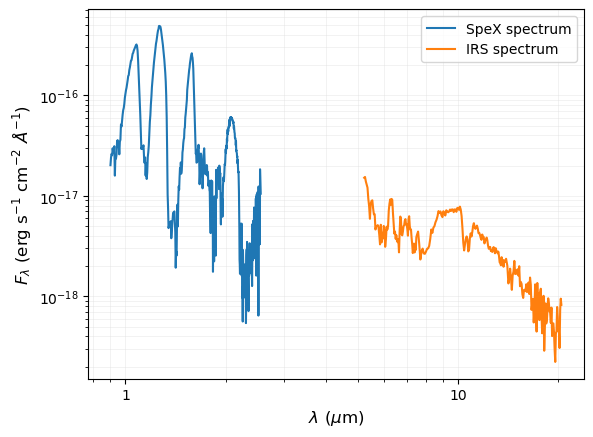

In [4]:
fig, ax = plt.subplots()

plt.plot(wl_SpeX, flux_SpeX, label='SpeX spectrum')
plt.plot(wl_IRS, flux_IRS, label='IRS spectrum')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.xscale('log')
plt.yscale('log')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

ax.grid(True, which='both', color='gainsboro', linewidth=0.5, alpha=0.5)
ax.legend()

plt.xlabel(r'$\lambda\ (\mu$m)', size=12)
plt.ylabel(r'$F_\lambda\ ($erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=12)

plt.show()

**Read input data**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.InputData).

For any SEDA function, we can also see the function description directly on the notebook with the command ``help()``, e.g.:

``help(seda.input_parameters.InputData)``


Define lists with the input spectra:

In [5]:
# wavelenghts
wl_spectra = [wl_SpeX, wl_IRS] # in um
# fluxes
flux_spectra = [flux_SpeX, flux_IRS] # in erg/s/cm2/A
# flux uncertainties
eflux_spectra = [eflux_SpeX, eflux_IRS] # in erg/s/cm2/A
# specify flux units
flux_unit = 'erg/s/cm2/A'

# resolution of each input spectrum (used to convolve the model spectra)
res = [100, 100]
# reference wavelength at which the resolution is given
lam_res = [2.0, 10.0] # in um

# distance to the target (optional and used to derive a radius)
distance = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
edistance = 0.06 # pc

# load all the input data parameters
my_data = seda.InputData(wl_spectra=wl_spectra, flux_spectra=flux_spectra, 
                         eflux_spectra=eflux_spectra, flux_unit=flux_unit, res=res, 
                         lam_res=lam_res, distance=distance, edistance=edistance)


   Input data loaded successfully


Download (if not yet) the atmospheric models you want to use. 

See the available atmospheric models with the command below and read more about them [here](https://seda.readthedocs.io/en/latest/overview.html#available-atmospheric-models). 

Also consider [this tutorial](https://seda.readthedocs.io/en/latest/notebooks/tutorial_models_examination.html) to explore the free parameters in the models and their coverage.

In [6]:
# available atmospheric models
seda.available_models()

{'Sonora_Diamondback': 'Morley et al (2024)',
 'Sonora_Elf_Owl': 'Mukherjee et al. (2024)',
 'LB23': 'Lacy & Burrows (2023)',
 'Sonora_Cholla': 'Karalidi et al. (2021)',
 'Sonora_Bobcat': 'Marley et al. (2021)',
 'ATMO2020': 'Phillips et al. (2020)',
 'BT-Settl': 'Allard et al. (2012)',
 'SM08': 'Saumon & Marley (2008)'}

**Read model grid options**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.ModelOptions).

In [7]:
# select the atmospheric models of interest
model = 'Sonora_Elf_Owl'
# path to the directory or directories containing the model spectra
model_dir = ['/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Elf_Owl/spectra/output_700.0_800.0/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Elf_Owl/spectra/output_850.0_950.0/',
            ]
# set parameter ranges to select a grid subset and to be used as uniform priors
# when a free parameter range is not specified, the whole grid range will be explored
Teff_range = np.array((700, 900)) # Teff range
logg_range = np.array((4.0, 5.0)) # logg range

# load model options
my_model = seda.ModelOptions(model=model, model_dir=model_dir, 
                             logg_range=logg_range, Teff_range=Teff_range)


   Model options loaded successfully


**Tip:** If you plan to model several spectra from the same instrument (same resolution), you can save the convolved model spectra to reuse them and do subsequent fits much faster. For this, set the parameter ``path_save_spectra_conv`` in ``seda.ModelOptions`` above to a folder path where you want to store the convolved spectra. Once the spectra are stored, the next time you run the code just replace ``model_dir`` by the path you used in ``path_save_spectra_conv`` and set ``skip_convolution=True`` to avoid the model convolution. This was suggested in this [issue](https://github.com/suarezgenaro/seda/issues/14).

**Read chi-square fit options**

Look at the input parameters [here](https://seda.readthedocs.io/en/latest/api.html#seda.input_parameters.Chi2Options).

Consider the default full wavelength range of each input spectrum for the fits. Otherwise, we can use the parameter ``fit_wl_range`` to set different fit ranges.

In [8]:
# choose a filename (optional) to save the sampling results as a pickle file
# it is convenient to set a non-default name when running 
# the code several times in the same folder to avoid overwriting results
chi2_pickle_file = f'{model}_chi2_minimization_multiple_spectra.pickle'
chi2_table_file = f'{model}_chi2_minimization_multiple_spectra.dat'

# load chi-square fit options
my_chi2 = seda.Chi2Options(my_data=my_data, my_model=my_model,
                           chi2_pickle_file=chi2_pickle_file,
                           chi2_table_file=chi2_table_file)


   Chi-square fit options loaded successfully


**Run chi-square fit**

In [9]:
out_chi2 = seda.chi2(my_chi2=my_chi2)


   Running chi-square fitting...

      3000 model spectra selected with:
         Teff=[700, 900]
         logg=[4.0, 5.0]


Convolving the spectra:   0%|          | 0/3000 [00:00<?, ?it/s]

Resampling the spectra:   0%|          | 0/3000 [00:00<?, ?it/s]

Minimizing chi-square:   0%|          | 0/3000 [00:00<?, ?it/s]

      chi-square minimization results saved successfully

   Chi-square fit ran successfully
      elapsed time: 9.8 min


**Plot results**

SED with the best three fits.

The pickle file generated by ``seda.chi2_fit`` and stored with the name ``my_chi2.chi2_pickle_file`` is the input file to make plots. We can provide the name by either using ``my_chi2.chi2_pickle_file`` (if ``my_chi2`` is in memory) or just typing it.

*Note that Elf Owl models do not cover wavelenghts longer than 15 microns.*

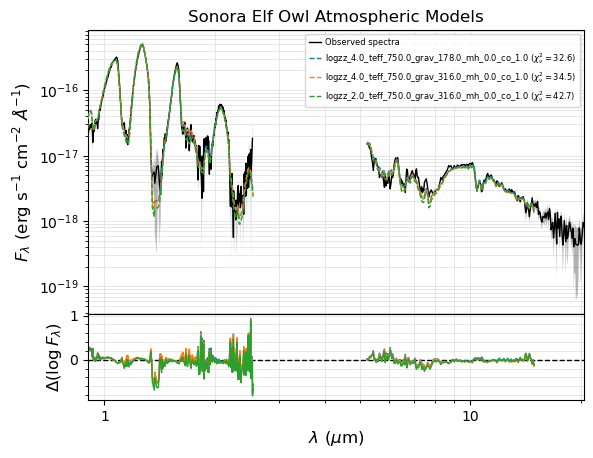

In [10]:
# plot wavelengths in logarithmic scale
chi2_pickle_file = 'Sonora_Elf_Owl_chi2_minimization_multiple_spectra.pickle'
seda.plot_chi2_fit(chi2_pickle_file, N_best_fits=3, xlog=True)

Zoom in on the SpeX spectrum:

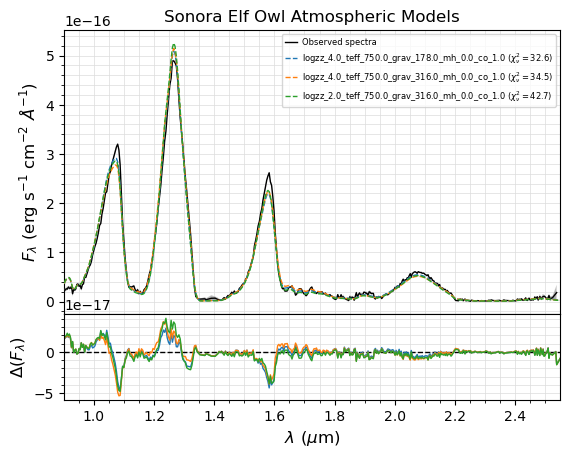

In [11]:
# plot fluxes in linear scale
seda.plot_chi2_fit(chi2_pickle_file, N_best_fits=3, 
                   xrange=[wl_SpeX.min(), wl_SpeX.max()], 
                   ylog=False, save=False)

Zoom in on the IRS spectrum:

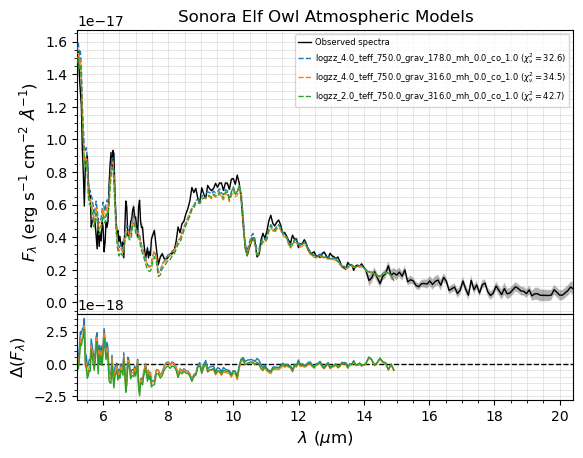

In [12]:
# plot fluxes in linear scale
seda.plot_chi2_fit(chi2_pickle_file, N_best_fits=3,
                   xrange=[wl_IRS.min(), wl_IRS.max()], 
                   ylog=False)

Reduced chi-square as a function of wavelength for the best three fits.

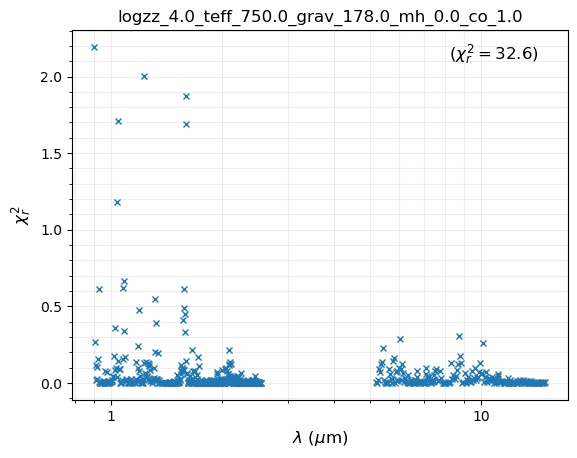

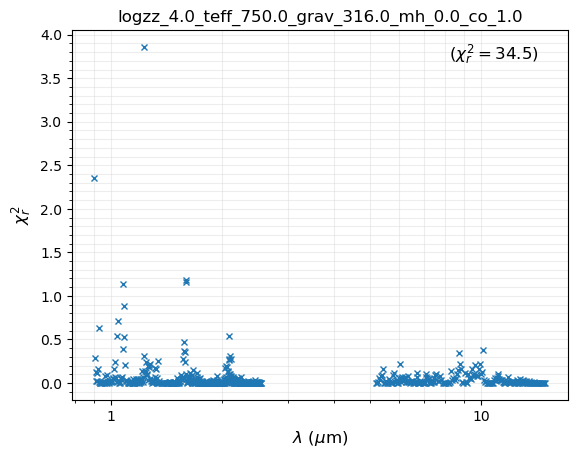

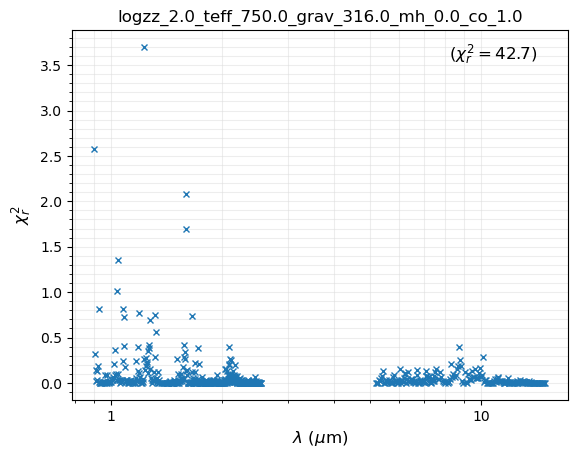

In [13]:
seda.plot_chi2_red(chi2_pickle_file, N_best_fits=3, xlog=True)